# World Bank

## Aims
Retrieve data from primary source using an API.

Learn usage of "wbgapi" library provided by the World Bank (WB).

Focus on "World Development Indicators" and demography.

Visualise with a variety of plotting libraries, including Plotly.

## Data
This API can access over 17,000 indicators from over 60 World Bank databases.

Each indicator is identified by a dot-seprated abbreviation, for example among those I have used are NY.GDP.PCAP.CD (GDP per capita) and SP.POP.TOTL (population total).

## Previous knowledge
For population the WB is a secondary source, using UN WPP and national census data, but is easier to use than UN data (which sometimes is retrospectively updated online causing a mismatch between publication and citation).

The list of countries used by different organisations almost always varies in length and membership. For example the IUCN biodiversity data counts each overseas territory (e.g. Ascension Island) as a separate country, which makes sense for them because islands often have lots of unique species. Another example is the World Bank has no data for Taiwan (population 24 million) because they want to avoid offending China.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [2]:
import wbgapi as wb

## World Bank API

In [8]:
# I have previously used a database called "World Development Indicators" (WDI).
wb.source.info(q="World Development Indicators")

id    name                          code      concepts  lastupdated
----  ----------------------------  ------  ----------  -------------
2     World Development Indicators  WDI              3  2023-10-26
      1 elements


In [21]:
# Use that id to retrieve all feature columns in WDI dataset.
print(type(wb.series.info(db=2)))

# To count columns, first convert wbgapi package's Featureset output into a list.
features = wb.series.list(db=2)
print(f"{len(list(features))} columns in WDI")

<class 'wbgapi.Featureset'>
1477 columns in WDI


In [ ]:
# Remember I already know some features e.g. SP.POP.TOTL (total population)

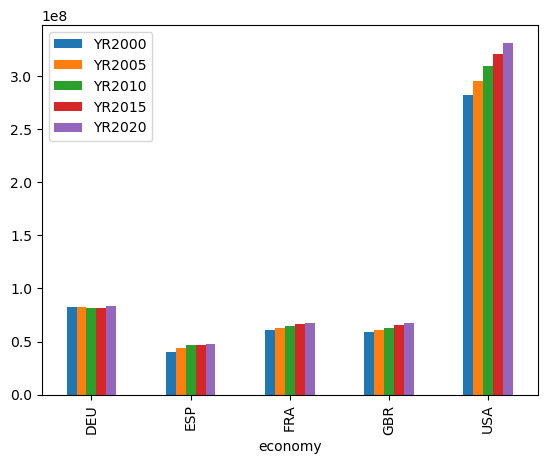

In [116]:
# pandas built-in plot function is easiest way to make a chart from WB
wb.data.DataFrame('SP.POP.TOTL', ['DEU','FRA','ESP','GBR','USA'], time=range(2000,2022,5)).plot.bar();

In [118]:
type(wb.data.DataFrame('SP.POP.TOTL', ['DEU','FRA','ESP','GBR','USA'], time=range(2000,2022,5)))

<class 'pandas.core.frame.DataFrame'>

In [3]:
# by default, dataframe is wide format (un-Tidy) with years in columns
pop5 = wb.data.DataFrame('SP.POP.TOTL',
                      ['DEU','ESP','GBR','POL'],
                      time=range(2000,2016,5));
pop5

,YR2000,YR2005,YR2010,YR2015
economy,,,,
DEU,82211508.0,82469422.0,81776930.0,81686611.0
ESP,40567864.0,43653155.0,46576897.0,46444832.0
GBR,58892514.0,60401206.0,62766365.0,65116219.0
POL,38258629.0,38165445.0,38042794.0,37986412.0


In [4]:
# later will make long narrow Tidy format using .melt() but meanwhile...
# Seaborn can cope with wide-format but needs transposing
pop5T = pop5.transpose()
pop5T

economy,DEU,ESP,GBR,POL
YR2000,82211508.0,40567864.0,58892514.0,38258629.0
YR2005,82469422.0,43653155.0,60401206.0,38165445.0
YR2010,81776930.0,46576897.0,62766365.0,38042794.0
YR2015,81686611.0,46444832.0,65116219.0,37986412.0


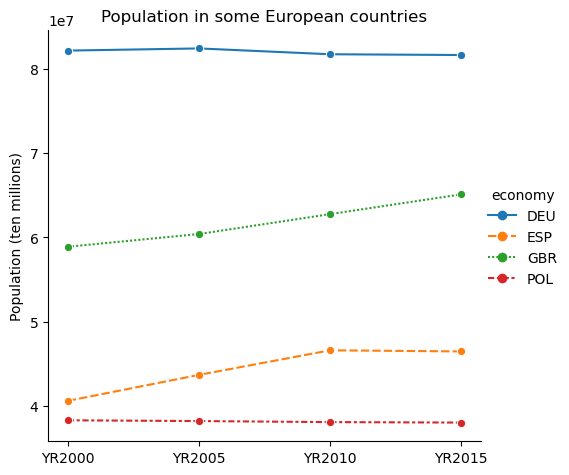

In [5]:
# I read that Seaborn.relplot can handle wide-format 
## WB calls a country an "economy"
## How can the Y scale be changed to plain millions?
## Tight layout warning caused by old version MatPlotLib # updated, fixed
sns.relplot(data=pop5T, kind='line', marker='o')
plt.ylabel("Population (ten millions)")
plt.title("Population in some European countries")
plt.show()

## Time-series with null values

In [43]:
# I picked European data for an easy plot with no Nulls.
# Now to get some patchy data with lots of Nulls.
wb.region.info(q="Africa")

code,name
AFE,Africa Eastern and Southern
AFR,Africa
AFW,Africa Western and Central
CAA,Sub-Saharan Africa (IFC classification)
CME,Middle East and North Africa (IFC classification)
MEA,Middle East & North Africa
MNA,Middle East & North Africa (excluding high income)
NAF,North Africa
NRS,Non-resource rich Sub-Saharan Africa countries
RRS,Resource rich Sub-Saharan Africa countries


In [9]:
gdp_africa = wb.data.DataFrame('NY.GDP.PCAP.CD', wb.region.members('AFR'))
print(len(gdp_africa))
print(gdp_africa.head())

54
            YR1960     YR1961     YR1962     YR1963      YR1964      YR1965  \
economy                                                                       
AGO            NaN        NaN        NaN        NaN         NaN         NaN   
BDI      71.360224  72.088782  73.942008  78.948269   85.964725   50.990420   
BEN      90.035831  92.374860  91.171392  96.254664  100.468088  105.966856   
BFA      69.083195  72.173766  77.077334  78.829086   80.833860   81.993527   
BWA      59.297122  62.742953  66.448679  69.378850   74.014392   80.193828   

             YR1966      YR1967      YR1968      YR1969  ...       YR2013  \
economy                                                  ...                
AGO             NaN         NaN         NaN         NaN  ...  5101.983876   
BDI       51.808640   54.450305   54.647466   55.543775  ...   241.547666   
BEN      108.628227  107.682862  112.477968  111.695273  ...  1214.295566   
BFA       82.759216   84.559491   84.919326   86.715117  .

In [10]:
# Almost half of countries have no GDP data for 1960s, now almost all do.
# However gaps in time series may also happen when a country splits creating a new country.
nullCount = gdp_africa.isnull().sum()
print(nullCount[nullCount > 0])

YR1960    23
YR1961    22
YR1962    21
YR1963    21
YR1964    21
          ..
YR2018     2
YR2019     2
YR2020     2
YR2021     2
YR2022     2
Length: 63, dtype: int64


In [11]:
# Transpose to put countries as columns, years as rows
gdp_africa_t = wb.data.DataFrame('NY.GDP.PCAP.CD', wb.region.members('AFR'), index='time', numericTimeKeys=True, labels=True)
gdp_africa_t.head()

,Time,AGO,BDI,BEN,BFA,BWA,CAF,CIV,CMR,COD,...,SWZ,SYC,TCD,TGO,TUN,TZA,UGA,ZAF,ZMB,ZWE
time,,,,,,,,,,,,,,,,,,,,,
2022,2022,2998.501158,238.441876,1303.222014,832.884266,7737.654681,427.058096,2486.412194,1588.478723,586.464289,...,4039.518036,15874.540068,716.804381,918.376756,3776.667779,1192.403809,964.224385,6776.480077,1487.907764,1266.996031
2021,2021,1903.717405,221.157803,1361.100749,893.077196,7238.796096,461.137511,2613.378893,1666.932809,577.209215,...,3982.905229,12963.064672,685.690315,964.050010,3807.184563,1146.031982,883.465728,7055.055176,1137.344395,1773.920411
2020,2020,1502.950754,216.827417,1237.949295,833.244336,5875.070606,435.469248,2349.069882,1539.130547,524.666686,...,3372.904639,12020.021914,643.772216,875.245410,3497.733231,1104.164429,846.881199,5741.641249,956.831747,1372.696674
2019,2019,2142.238757,216.972971,1170.965533,772.166878,6691.161051,426.408753,2290.787379,1538.687912,575.882781,...,3818.540425,16851.119765,701.621201,848.304827,3477.844271,1050.932373,823.024733,6688.774746,1268.120941,1421.868596
2018,2018,2487.500996,232.060617,1194.438214,779.202768,6947.817841,435.932296,2295.540335,1594.060109,546.212593,...,4021.445556,16409.471128,720.265101,873.555156,3577.169460,1011.599670,793.128082,7048.508112,1475.199836,2269.177012


In [12]:
# see which countries (only countrycodes for now) have missing years of data
nullCount = gdp_africa_t.isnull().sum()
print(nullCount[nullCount > 0])

AGO    20
COM    20
CPV    20
DJI    26
EGY     5
ERI    43
ETH    21
GIN    26
GMB     6
GNB    10
GNQ     4
LBR    40
LBY    30
MLI     7
MOZ    31
MRT     1
MUS    16
MWI    20
NAM    20
SOM    22
SSD    55
STP    41
TUN     5
TZA    28
dtype: int64


In [28]:
top5gdp = gdp_africa.sort_values(by=['YR2022'],ascending=False)[:3]
print(top5gdp)

             YR1960      YR1961      YR1962      YR1963      YR1964  \
economy                                                               
SYC      288.058159  270.279661  287.044788  308.195264  332.305003   
MUS             NaN         NaN         NaN         NaN         NaN   
GAB      275.585338  322.797124  347.684538  290.053633  399.532918   

             YR1965      YR1966      YR1967      YR1968      YR1969  ...  \
economy                                                              ...   
SYC      328.484901  337.646247  333.233812  314.351065  314.179853  ...   
MUS             NaN         NaN         NaN         NaN         NaN  ...   
GAB      413.625221  442.376368  481.088521  513.359340  544.148931  ...   

               YR2013        YR2014        YR2015        YR2016        YR2017  \
economy                                                                         
SYC      14729.627030  15188.174278  14894.485783  15409.805019  15961.241682   
MUS       9764.64402

In [29]:
nullCount = top5gdp.isnull().sum()
print(nullCount[nullCount > 0])

YR1960    1
YR1961    1
YR1962    1
YR1963    1
YR1964    1
YR1965    1
YR1966    1
YR1967    1
YR1968    1
YR1969    1
YR1970    1
YR1971    1
YR1972    1
YR1973    1
YR1974    1
YR1975    1
dtype: int64


In [30]:
top5gdpT = top5gdp.transpose()
print(top5gdpT)

economy           SYC           MUS          GAB
YR1960     288.058159           NaN   275.585338
YR1961     270.279661           NaN   322.797124
YR1962     287.044788           NaN   347.684538
YR1963     308.195264           NaN   290.053633
YR1964     332.305003           NaN   399.532918
...               ...           ...          ...
YR2018   16409.471128  11643.460596  7694.906045
YR2019   16851.119765  11403.252894  7523.862278
YR2020   12020.021914   9005.462022  6680.082670
YR2021   12963.064672   9062.722476  8635.797144
YR2022   15874.540068  10216.294744  8820.347338

[63 rows x 3 columns]


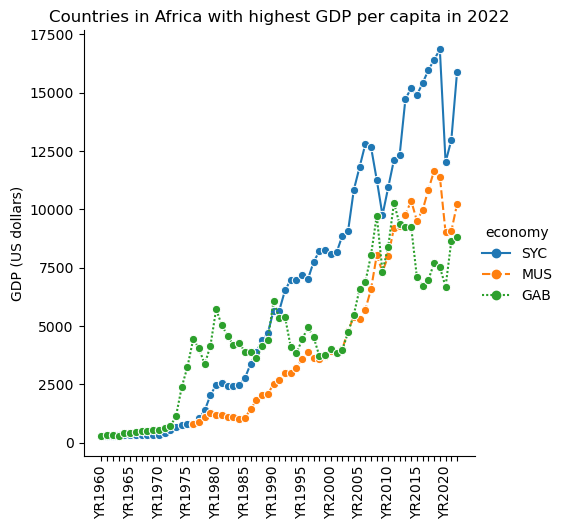

In [119]:
sns.relplot(data=top5gdpT, kind='line', marker='o')
plt.ylabel("GDP (US dollars)")
plt.title("Countries in Africa with highest GDP per capita in 2022")
plt.xticks(rotation=90)
ax = plt.gca()
temp = ax.xaxis.get_ticklabels()
temp = list(set(temp) - set(temp[::5]))
for label in temp:
    label.set_visible(False)
plt.show()

In [ ]:
# country "MUS" time-series begins in 1976
# Names of countries are needed, but first (so global comparisons can be done) 
# need to remove any regional agglomerations so all data is for individual countries.

## Remove all supra-national regions

In [6]:
wb.economy.info() # list country ISO 3-letter codes, and names
# includes supranational regions which is why it is labelled "economy" rather than "country"

id,value,region,incomeLevel
ABW,Aruba,LCN,HIC
AFE,Africa Eastern and Southern,,
AFG,Afghanistan,SAS,LIC
AFW,Africa Western and Central,,
AGO,Angola,SSF,LMC
ALB,Albania,ECS,UMC
AND,Andorra,ECS,HIC
ARB,Arab World,,
ARE,United Arab Emirates,MEA,HIC
ARG,Argentina,LCN,UMC


In [43]:
# need a list of countries, to match against WB and only include these

import pycountry as cy
list(cy.countries)[:5]  # pycountry.ExistingCountries

[Country(alpha_2='AW', alpha_3='ABW', flag='🇦🇼', name='Aruba', numeric='533'),
 Country(alpha_2='AF', alpha_3='AFG', flag='🇦🇫', name='Afghanistan', numeric='004', official_name='Islamic Republic of Afghanistan'),
 Country(alpha_2='AO', alpha_3='AGO', flag='🇦🇴', name='Angola', numeric='024', official_name='Republic of Angola'),
 Country(alpha_2='AI', alpha_3='AIA', flag='🇦🇮', name='Anguilla', numeric='660'),
 Country(alpha_2='AX', alpha_3='ALA', flag='🇦🇽', name='Åland Islands', numeric='248')]

In [62]:
# get 3-letter codes for all countries in pycountry

countries = list(cy.countries)
py_country_codes = [country.alpha_3 for country in countries]
print(len(py_country_codes))
print(py_country_codes[0:9])

249
['ABW', 'AFG', 'AGO', 'AIA', 'ALA', 'ALB', 'AND', 'ARE', 'ARG']


In [63]:
# now to check country list in WB; first see how they appear
df = wb.data.DataFrame('SP.POP.TOTL', time=2022)
print(len(df))
print(df.head())

266
         SP.POP.TOTL
economy             
ABW         106445.0
AFE      720839314.0
AFG       41128771.0
AFW      490330870.0
AGO       35588987.0


In [64]:
# move WB countrycodes from index to column
df.reset_index(inplace=True)
print(df['economy'].head())

0    ABW
1    AFE
2    AFG
3    AFW
4    AGO
Name: economy, dtype: object


In [61]:
# get codes for all regions & countries from WorldBank SP data into a list
# aim is to separate those that coincide with pycountry 
# and visually inspect to check the remainder are regions.

df = wb.data.DataFrame('SP.POP.TOTL', time=2022)
df = df.reset_index()
wb_country_codes = list(df.economy)
# %pprint
print(wb_country_codes[:10])

['ABW', 'AFE', 'AFG', 'AFW', 'AGO', 'ALB', 'AND', 'ARB', 'ARE', 'ARG']


In [48]:
df.columns

Index(['economy', 'SP.POP.TOTL'], dtype='object')

In [81]:
# WorldBank rows that are countries according to pycountry
dfc = df[df['economy'].isin(py_country_codes)]
print(len(dfc))

215


In [82]:
print(dfc.head(3))
# gaps in index where noncountries were omitted

  economy  SP.POP.TOTL
0     ABW     106445.0
2     AFG   41128771.0
4     AGO   35588987.0


In [83]:
# inverse (with tilde) to get WB rows that are NOT countries
dfr = df[~df['economy'].isin(py_country_codes)]
print(len(dfr))

51


In [80]:
# view some of the 51 non-countries in WB data
print(dfr.tail(3))

    economy   SP.POP.TOTL
249     UMC  2.784208e+09
259     WLD  7.951150e+09
261     XKX  1.761985e+06


In [ ]:
# e.g. WLD = World, and (not in tail view) EMU = Eurozone (European Monetary Union)

In [ ]:
# Curious: which countries in pycountry list are not in World Bank list?

## Names of countries

In [68]:
# now need names of economy/country for visual inspection
# wbgapi doesn't seem to have these but another library does
import wbdata as wbd

In [70]:
all_wb_economy = wbd.get_country()
print(type(all_wb_economy))
print(all_wb_economy)

<class 'wbdata.api.WBSearchResult'>
id    name
----  --------------------------------------------------------------------------------
ABW   Aruba
AFE   Africa Eastern and Southern
AFG   Afghanistan
AFR   Africa
AFW   Africa Western and Central
AGO   Angola
ALB   Albania
AND   Andorra
ARB   Arab World
ARE   United Arab Emirates
ARG   Argentina
ARM   Armenia
ASM   American Samoa
ATG   Antigua and Barbuda
AUS   Australia
AUT   Austria
AZE   Azerbaijan
BDI   Burundi
BEA   East Asia & Pacific (IBRD-only countries)
BEC   Europe & Central Asia (IBRD-only countries)
BEL   Belgium
BEN   Benin
BFA   Burkina Faso
BGD   Bangladesh
BGR   Bulgaria
BHI   IBRD countries classified as high income
BHR   Bahrain
BHS   Bahamas, The
BIH   Bosnia and Herzegovina
BLA   Latin America & the Caribbean (IBRD-only countries)
BLR   Belarus
BLZ   Belize
BMN   Middle East & North Africa (IBRD-only countries)
BMU   Bermuda
BOL   Bolivia
BRA   Brazil
BRB   Barbados
BRN   Brunei Darussalam
BSS   Sub-Saharan Africa (IBR

In [51]:
# convert custom type into a Dictionary
country_codes_mapping = {country['id']: country['name'] for country in all_wb_economy}
print(type(country_codes_mapping))

<class 'dict'>


In [71]:
# View it - to avoid printing whole dictionary (250+ items) use iterator
from itertools import islice
for key, value in islice(country_codes_mapping.items(), 5):
    print(f"{key}: {value}")

ABW: Aruba
AFE: Africa Eastern and Southern
AFG: Afghanistan
AFR: Africa
AFW: Africa Western and Central


In [73]:
# add Name column to the dfr of suspected noncountries

# prepare new column in a list
country_names = []
dfr_copy = dfr.copy()

# from each country code look up associated name
for code in dfr['economy']:
    if code in country_codes_mapping:
        country_names.append(country_codes_mapping[code])
    else:
        country_names.append("Not Found")

# Add the 'Country Name' column to the DataFrame
dfr_copy.loc[:, 'Name'] = country_names
dfr_copy[['economy', 'Name']]

# show all because I want to see if any countries in there

,economy,Name
1,AFE,Africa Eastern and Southern
3,AFW,Africa Western and Central
7,ARB,Arab World
36,CEB,Central Europe and the Baltics
38,CHI,Channel Islands
49,CSS,Caribbean small states
61,EAP,East Asia & Pacific (excluding high income)
62,EAR,Early-demographic dividend
63,EAS,East Asia & Pacific
64,ECA,Europe & Central Asia (excluding high income)


In [ ]:
# yes those are all noncountry aggregates
# except Kosovo which is in World Bank data but not in pycountry list

In [88]:
dfcn = dfc.copy()
country_names = []

# Iterate through each country code and look up the corresponding country or region name
for code in dfc['economy']:
    if code in country_codes_mapping:
        country_names.append(country_codes_mapping[code])
    else:
        country_names.append("Not Found")

# Add the 'Country Name' column to the DataFrame
dfcn['Country_name'] = country_names

dfcn.rename(columns={"economy": "Code", "SP.POP.TOTL": "Population"}, inplace=True)

# rearrange columns order
cols = ['Code', 'Country_name', 'Population']
dfcn = dfcn[cols]

# dfcn[['Code', 'Country_name']]
print(dfcn.head())

  Code Country_name  Population
0  ABW        Aruba    106445.0
2  AFG  Afghanistan  41128771.0
4  AGO       Angola  35588987.0
5  ALB      Albania   2775634.0
6  AND      Andorra     79824.0


In [89]:
pop_10 = dfcn.sort_values("Population", ascending=False)[:10]
print(pop_10)

    Code        Country_name    Population
109  IND               India  1.417173e+09
40   CHN               China  1.412175e+09
251  USA       United States  3.332876e+08
106  IDN           Indonesia  2.755013e+08
184  PAK            Pakistan  2.358249e+08
174  NGA             Nigeria  2.185412e+08
29   BRA              Brazil  2.153135e+08
20   BGD          Bangladesh  1.711864e+08
202  RUS  Russian Federation  1.435557e+08
154  MEX              Mexico  1.275041e+08


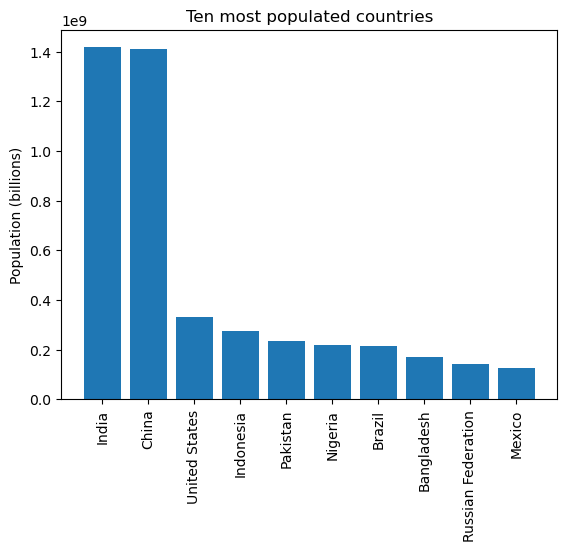

In [93]:
plt.bar(x='Country_name', height='Population', data=pop_10)
plt.xticks(rotation=90)
plt.title("Ten most populated countries")
plt.ylabel("Population (billions)")
plt.show()

In [96]:
# Plotly, same data
fig = px.bar(pop_10, x="Code", y="Population", hover_data=["Country_name", "Population"], title="Ten most populated countries", labels={'x': 'Country', 'y': 'Population (billions)'})
fig.update_layout(xaxis_title='Country', yaxis_title='Population (billions)')
fig.show()

In [97]:
dfcn.to_csv('pop_2022.csv', sep=',', index=False, encoding='utf-8')

## Time series for one country

In [107]:
dfgb = wb.data.DataFrame('SP.POP.TOTL', 'GBR', time=range(1960, 2023, 5))
dfgb

,YR1960,YR1965,YR1970,YR1975,YR1980,YR1985,YR1990,YR1995,YR2000,YR2005,YR2010,YR2015,YR2020
economy,,,,,,,,,,,,,
GBR,52400000.0,54348050.0,55663250.0,56225800.0,56314216.0,56550268.0,57247586.0,58019030.0,58892514.0,60401206.0,62766365.0,65116219.0,67081234.0


In [108]:
# prepare for melt() by making index into a column
dfgb.reset_index(inplace=True)
dfgb

,economy,YR1960,YR1965,YR1970,YR1975,YR1980,YR1985,YR1990,YR1995,YR2000,YR2005,YR2010,YR2015,YR2020
0,GBR,52400000.0,54348050.0,55663250.0,56225800.0,56314216.0,56550268.0,57247586.0,58019030.0,58892514.0,60401206.0,62766365.0,65116219.0,67081234.0


In [109]:
gb_long = pd.melt(dfgb, id_vars='economy', var_name='year', value_name='population')
gb_long
# Plotting the bar chart
# df_long.plot(x='Year', y='Value', kind='bar', legend=False, color='skyblue')

,economy,year,population
0,GBR,YR1960,52400000.0
1,GBR,YR1965,54348050.0
2,GBR,YR1970,55663250.0
3,GBR,YR1975,56225800.0
4,GBR,YR1980,56314216.0
5,GBR,YR1985,56550268.0
6,GBR,YR1990,57247586.0
7,GBR,YR1995,58019030.0
8,GBR,YR2000,58892514.0
9,GBR,YR2005,60401206.0


In [114]:
fig = px.bar(gb_long, x="year", y="population", title="GB population 1960-2020")
fig.update_layout(xaxis_title='Year', yaxis_title='Population (millions)')
fig.show()

That's all for now!

In [5]:
for row in wb.data.fetch('SP.POP.TOTL', 'GBR', time=range(1960, 2023, 5)):
    print(row)

{'value': 67081234, 'series': 'SP.POP.TOTL', 'economy': 'GBR', 'aggregate': False, 'time': 'YR2020'}
{'value': 65116219, 'series': 'SP.POP.TOTL', 'economy': 'GBR', 'aggregate': False, 'time': 'YR2015'}
{'value': 62766365, 'series': 'SP.POP.TOTL', 'economy': 'GBR', 'aggregate': False, 'time': 'YR2010'}
{'value': 60401206, 'series': 'SP.POP.TOTL', 'economy': 'GBR', 'aggregate': False, 'time': 'YR2005'}
{'value': 58892514, 'series': 'SP.POP.TOTL', 'economy': 'GBR', 'aggregate': False, 'time': 'YR2000'}
{'value': 58019030, 'series': 'SP.POP.TOTL', 'economy': 'GBR', 'aggregate': False, 'time': 'YR1995'}
{'value': 57247586, 'series': 'SP.POP.TOTL', 'economy': 'GBR', 'aggregate': False, 'time': 'YR1990'}
{'value': 56550268, 'series': 'SP.POP.TOTL', 'economy': 'GBR', 'aggregate': False, 'time': 'YR1985'}
{'value': 56314216, 'series': 'SP.POP.TOTL', 'economy': 'GBR', 'aggregate': False, 'time': 'YR1980'}
{'value': 56225800, 'series': 'SP.POP.TOTL', 'economy': 'GBR', 'aggregate': False, 'time': 

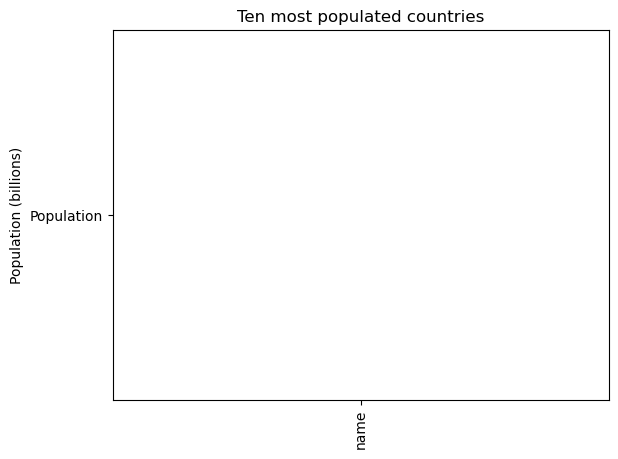

In [28]:
plt.bar(x='name', height='Population', data=dfgb)
plt.xticks(rotation=90)
plt.title("Ten most populated countries")
plt.ylabel("Population (billions)")
plt.show()

In [13]:
wba.series.info(q='renewable electricity output')

id,value
EG.ELC.RNEW.ZS,Renewable electricity output (% of total electricity output)
,1 elements


            YR2000     YR2005     YR2010     YR2015
economy                                            
DEU       6.198531  10.150211  16.727074  29.231770
ESP      15.613726  14.601392  32.775543  34.949891
FRA      12.967876   9.860647  13.857359  15.857667
GBR       2.663105   4.283482   6.812813  24.840050
USA       8.205997   8.578466  10.120355  13.228593


<Axes: xlabel='economy'>

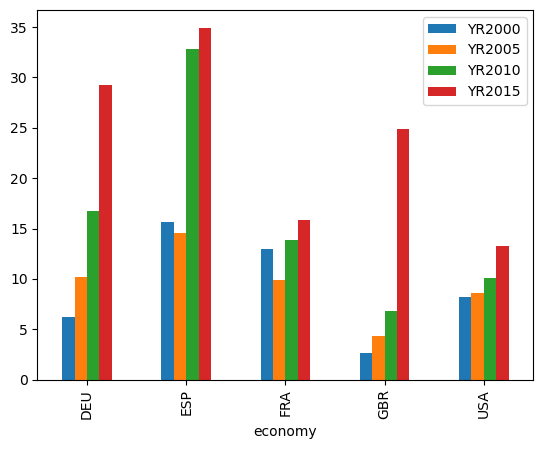

In [14]:
renewable_5 = wba.data.DataFrame('EG.ELC.RNEW.ZS',
                      ['DEU','FRA','ESP','GBR','USA'],
                      time=range(2000,2016,5))
print(renewable_5)
renewable_5.plot.bar()

<Axes: >

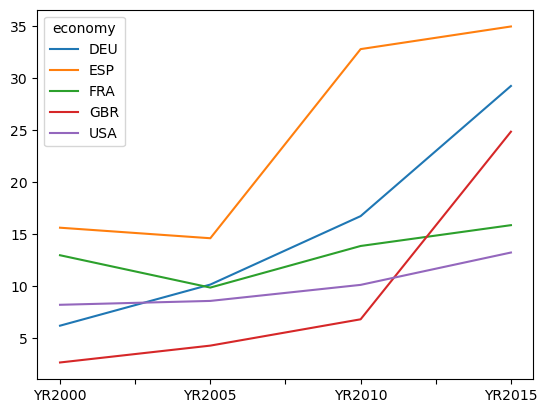

In [15]:
wba.data.DataFrame('EG.ELC.RNEW.ZS',
       ['DEU','FRA','ESP','GBR','USA'],
       time=range(2000,2016,5)).T.plot()

In [104]:
dft = wb.data.DataFrame('SP.POP.TOTL')
dft.head()

,YR1960,YR1961,YR1962,YR1963,YR1964,YR1965,YR1966,YR1967,YR1968,YR1969,...,YR2013,YR2014,YR2015,YR2016,YR2017,YR2018,YR2019,YR2020,YR2021,YR2022
economy,,,,,,,,,,,,,,,,,,,,,
ABW,54608.0,55811.0,56682.0,57475.0,58178.0,58782.0,59291.0,59522.0,59471.0,59330.0,...,102880.0,103594.0,104257.0,104874.0,105439.0,105962.0,106442.0,106585.0,106537.0,106445.0
AFE,130692579.0,134169237.0,137835590.0,141630546.0,145605995.0,149742351.0,153955516.0,158313235.0,162875171.0,167596160.0,...,567892149.0,583651101.0,600008424.0,616377605.0,632746570.0,649757148.0,667242986.0,685112979.0,702977106.0,720839314.0
AFG,8622466.0,8790140.0,8969047.0,9157465.0,9355514.0,9565147.0,9783147.0,10010030.0,10247780.0,10494489.0,...,31541209.0,32716210.0,33753499.0,34636207.0,35643418.0,36686784.0,37769499.0,38972230.0,40099462.0,41128771.0
AFW,97256290.0,99314028.0,101445032.0,103667517.0,105959979.0,108336203.0,110798486.0,113319950.0,115921723.0,118615741.0,...,387204553.0,397855507.0,408690375.0,419778384.0,431138704.0,442646825.0,454306063.0,466189102.0,478185907.0,490330870.0
AGO,5357195.0,5441333.0,5521400.0,5599827.0,5673199.0,5736582.0,5787044.0,5827503.0,5868203.0,5928386.0,...,26147002.0,27128337.0,28127721.0,29154746.0,30208628.0,31273533.0,32353588.0,33428486.0,34503774.0,35588987.0


In [16]:
usa = wba.data.DataFrame('SP.POP.TOTL', 'USA')
print(usa.shape)

(1, 63)


In [17]:
usa = wba.data.DataFrame('SP.POP.TOTL', 'USA').transpose()
usa.shape

(63, 1)

<Axes: title={'center': 'Population USA'}>

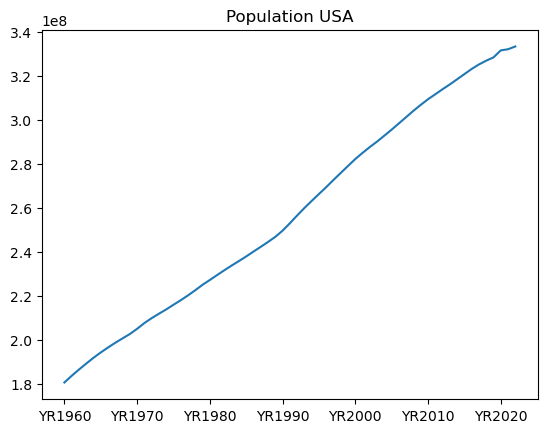

In [18]:
usa = wba.data.DataFrame('SP.POP.TOTL', 'USA').transpose()
df = pd.DataFrame(usa)
df['USA'].plot(x='USA', kind="line", title="Population USA")

<Axes: title={'center': 'GDP per capita USA'}>

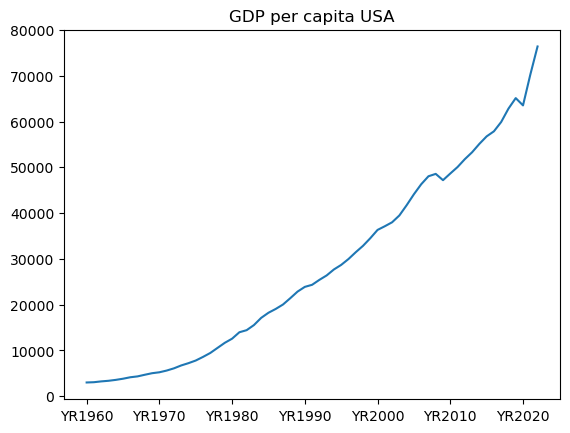

In [19]:
usa = wba.data.DataFrame('NY.GDP.PCAP.CD', 'USA').transpose()
df = pd.DataFrame(usa)
df['USA'].plot(x='USA', kind="line", title="GDP per capita USA")

<Axes: >

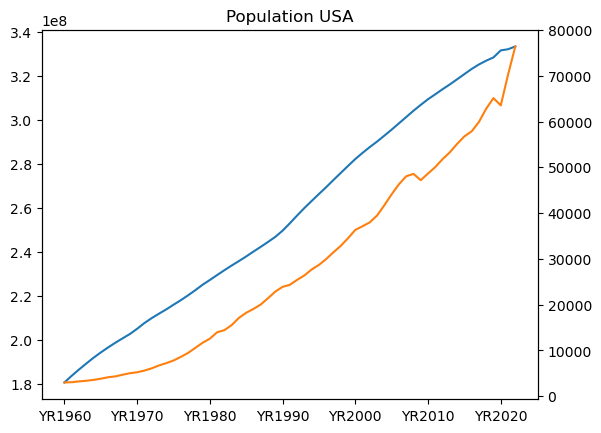

In [20]:
pop = wba.data.DataFrame('SP.POP.TOTL', 'USA').transpose()
dfp = pd.DataFrame(pop)
dfp['USA'].plot(x='USA', kind="line", title="Population USA")
gdp = wba.data.DataFrame('NY.GDP.PCAP.CD', 'USA').transpose()
dfg = pd.DataFrame(gdp)
dfg['USA'].plot(x='USA', kind="line", secondary_y=True)

In [10]:
wb.series.info(q="fertility")

id,value
SP.ADO.TFRT,"Adolescent fertility rate (births per 1,000 women ages 15-19)"
SP.DYN.TFRT.IN,"Fertility rate, total (births per woman)"
SP.DYN.WFRT,Wanted fertility rate (births per woman)
,3 elements


In [11]:
tfr = wb.data.DataFrame('SP.DYN.TFRT.IN', mrnev=1, columns='time', numericTimeKeys=True)
len(tfr)

261

In [46]:
notCountry = wb.data.DataFrame('SP.POP.TOTL', country_codes, time=2022)
notCountry

SyntaxError: invalid syntax (723107008.py, line 1)

In [31]:
pop = wb.data.DataFrame('SP.POP.TOTL', wb.region.members('EMU'))
pop

,YR1960,YR1961,YR1962,YR1963,YR1964,YR1965,YR1966,YR1967,YR1968,YR1969,...,YR2013,YR2014,YR2015,YR2016,YR2017,YR2018,YR2019,YR2020,YR2021,YR2022
economy,,,,,,,,,,,,,,,,,,,,,
AUT,7047539.0,7086299.0,7129864.0,7175811.0,7223801.0,7270889.0,7322066.0,7376998.0,7415403.0,7441055.0,...,8479823.0,8546356.0,8642699.0,8736668.0,8797566.0,8840521.0,8879920.0,8916864.0,8955797.0,9042528.0
BEL,9153489.0,9183948.0,9220578.0,9289770.0,9378113.0,9463667.0,9527807.0,9580991.0,9618756.0,9646032.0,...,11159407.0,11209057.0,11274196.0,11331422.0,11375158.0,11427054.0,11488980.0,11538604.0,11592952.0,11669446.0
CYP,585725.0,594771.0,601095.0,607072.0,612338.0,617345.0,622566.0,627695.0,632452.0,636821.0,...,1166968.0,1176995.0,1187280.0,1197881.0,1208523.0,1218831.0,1228836.0,1237537.0,1244188.0,1251488.0
DEU,72814900.0,73377632.0,74025784.0,74714353.0,75318337.0,75963695.0,76600311.0,76951336.0,77294314.0,77909682.0,...,80645605.0,80982500.0,81686611.0,82348669.0,82657002.0,82905782.0,83092962.0,83160871.0,83196078.0,84079811.0
ESP,30455000.0,30739250.0,31023366.0,31296651.0,31609195.0,31954292.0,32283194.0,32682947.0,33113134.0,33441054.0,...,46620045.0,46480882.0,46444832.0,46484062.0,46593236.0,46797754.0,47134837.0,47365655.0,47415750.0,47615034.0
EST,1211537.0,1225077.0,1241623.0,1258857.0,1277086.0,1294566.0,1308597.0,1318946.0,1331214.0,1345249.0,...,1317997.0,1314545.0,1315407.0,1315790.0,1317384.0,1321977.0,1326898.0,1329522.0,1330932.0,1344768.0
FIN,4429634.0,4461005.0,4491443.0,4523309.0,4548543.0,4563732.0,4580869.0,4605744.0,4626469.0,4623785.0,...,5438972.0,5461512.0,5479531.0,5495303.0,5508214.0,5515525.0,5521606.0,5529543.0,5541017.0,5556880.0
FRA,46649927.0,47161641.0,47679792.0,48189939.0,48733997.0,49282756.0,49817041.0,50334012.0,50817020.0,51272683.0,...,66002289.0,66312067.0,66548272.0,66724104.0,66918020.0,67158348.0,67388001.0,67571107.0,67749632.0,67935660.0
GRC,8331725.0,8398050.0,8448233.0,8479625.0,8510429.0,8550333.0,8613651.0,8684088.0,8740765.0,8772764.0,...,10965211.0,10892413.0,10820883.0,10775971.0,10754679.0,10732882.0,10721582.0,10698599.0,10641221.0,10566531.0


In [36]:
top5_2022 = pop.sort_values(by=['YR2022'], ascending=False)[:5]
print(top5_2022)

             YR1960      YR1961      YR1962      YR1963      YR1964  \
economy                                                               
DEU      72814900.0  73377632.0  74025784.0  74714353.0  75318337.0   
FRA      46649927.0  47161641.0  47679792.0  48189939.0  48733997.0   
ITA      50199700.0  50536350.0  50879450.0  51252000.0  51675350.0   
ESP      30455000.0  30739250.0  31023366.0  31296651.0  31609195.0   
NLD      11486631.0  11638712.0  11805689.0  11965966.0  12127120.0   

             YR1965      YR1966      YR1967      YR1968      YR1969  ...  \
economy                                                              ...   
DEU      75963695.0  76600311.0  76951336.0  77294314.0  77909682.0  ...   
FRA      49282756.0  49817041.0  50334012.0  50817020.0  51272683.0  ...   
ITA      52112350.0  52519000.0  52900500.0  53235750.0  53537950.0  ...   
ESP      31954292.0  32283194.0  32682947.0  33113134.0  33441054.0  ...   
NLD      12294732.0  12456251.0  12598201.0  1

<Axes: >

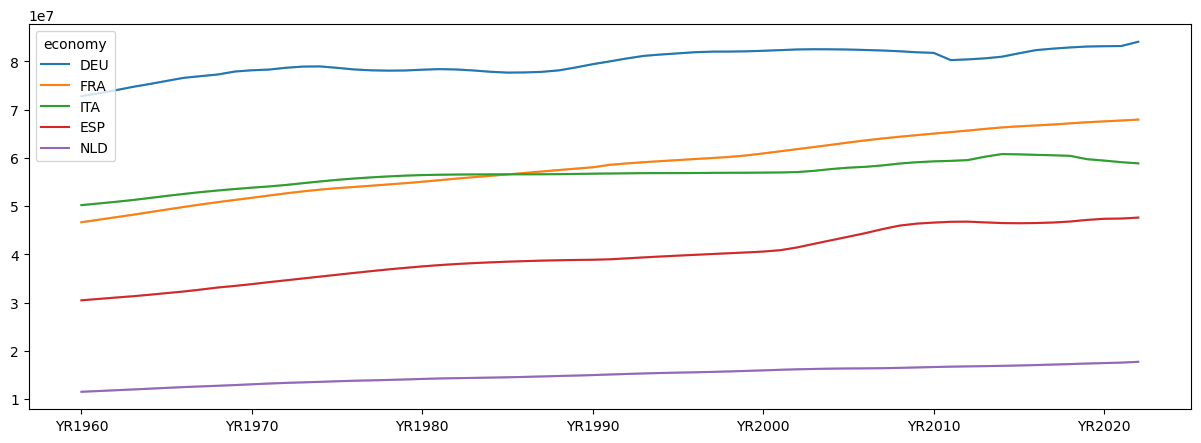

In [37]:
ax=top5_2022.T.plot(color='lightgray', legend=False)
top5_2022.T.plot(ax=ax, figsize=(15,5))